In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq,Linear,ReLU,BatchNorm1d
from torch_scatter import scatter_mean

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from InteractionNetwork import InteractionNetwork

<hr>
load pretrained model

In [2]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

<All keys matched successfully>

end of load pretrained model
<hr>
get data

In [233]:
# get data

import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [234]:
b=graph_dataset[0]
g=b[0]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[38], edge_index=[2, 1406], u=[1, 2], x=[38, 48], y=[1, 2])

end of get data<hr>

functions copied from `src.util`

In [235]:
def copy_layer(layer):
    """
    create a deep copy of provided layer
    """
    layer_cp=eval("nn."+layer.__repr__())
    layer_cp.load_state_dict(layer.state_dict())
    
    return layer_cp

In [239]:
copy_tensor=lambda x: torch.tensor(x.clone().detach().numpy(),requires_grad=True,dtype=torch.float32)

In [236]:
for i in (model.interactionnetwork.children()):
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            print(n,j.__repr__())

edge_mlp.0 Linear(in_features=96, out_features=128, bias=True)
edge_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
edge_mlp.2 ReLU()
edge_mlp.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_1.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_1.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_1.2 ReLU()
node_mlp_1.3 Linear(in_features=128, out_features=128, bias=True)
node_mlp_2.0 Linear(in_features=176, out_features=128, bias=True)
node_mlp_2.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
node_mlp_2.2 ReLU()
node_mlp_2.3 Linear(in_features=128, out_features=128, bias=True)
global_mlp.0 Linear(in_features=128, out_features=128, bias=True)
global_mlp.1 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
global_mlp.2 ReLU()
global_mlp.3 Linear(in_features=128, out_features=2, bias=True)


layer name `n` ends with 0-2 -> joint together, rectified linear layer
layer name `n` ends with 3 -> standalone linear layer

`R2` (`node_mlp_1.0-2`) and `R4` (`node_mlp_2.0-2`) contains partial relevance score of input `x`

In [237]:
layers={}
cnt=0
for i in (model.interactionnetwork.children()):
    layer=[]
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            if n[-1] in ["0","1","2"]:
                layer.append(copy_layer(j))
            else:
                layers[f"L{cnt}"]=Seq(*layer)
                layer=[]
                cnt+=1
                
                layers[f"L{cnt}"]=copy_layer(j)
                cnt+=1
layers

{'L0': Sequential(
   (0): Linear(in_features=96, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L1': Linear(in_features=128, out_features=128, bias=True),
 'L2': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L3': Linear(in_features=128, out_features=128, bias=True),
 'L4': Sequential(
   (0): Linear(in_features=176, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L5': Linear(in_features=128, out_features=128, bias=True),
 'L6': Sequential(
   (0): Linear(in_features=128, out_features=128, bias=True)
   (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 'L7': Linear(in_features=128, out_features=2, bias=True)}

In [240]:
row,col=g.edge_index
n_tracks=g.x.shape[0]
x=copy_tensor(torch.cat([g.x[row],g.x[col]],1))

In [241]:
activations={}
activations["a0"]=layers["L0"].forward(x)

In [242]:
M_col=torch.zeros(col.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(col):
    M_col[i,j]=1
M_col=M_col.T

In [243]:
M_row=torch.zeros(row.shape[0],n_tracks,dtype=torch.float32)
for i,j in enumerate(row):
    M_row[i,j]=1
M_row=M_row.T

In [244]:
for i in range(1,len(layers.keys())):
    if i==2:
        #a1->a1'
        a=copy_tensor(torch.cat([g.x[row],activations[f"a{i-1}"]],1))           # [x[row],a1]
    elif i==4:
        #a3->a3'
        a=copy_tensor(torch.cat([g.x,M_col@activations[f"a{i-1}"]/n_tracks],1)) # g.x,scatter_mean(a3,col,dim=0)
    elif i==6:
        #a5->a5'
        layers[f"L{i}"].eval()
        a=copy_tensor(torch.ones(1,n_tracks)@activations[f"a{i-1}"]/n_tracks)   # mean of all tracks
    else:
        a=copy_tensor(activations[f"a{i-1}"])
    
    activations[f"a{i}"]=layers[f"L{i}"].forward(a)

In [245]:
for k in activations.keys():
    print(k,activations[k].shape)

a0 torch.Size([1406, 128])
a1 torch.Size([1406, 128])
a2 torch.Size([1406, 128])
a3 torch.Size([1406, 128])
a4 torch.Size([38, 128])
a5 torch.Size([38, 128])
a6 torch.Size([1, 128])
a7 torch.Size([1, 2])


In [246]:
u=activations["a7"]

R={}
R[f"R{8}"]=copy_tensor(u@torch.tensor([[0,0],[0,1]],dtype=torch.float32))
R

{'R8': tensor([[ 0.0000, -1.6458]], requires_grad=True)}

In [247]:
def LRP(a,l,r,epsilon=1e-9):
    a=torch.tensor(a.clone().detach().numpy(),
                      requires_grad=True,dtype=torch.float32)
    a.retain_grad()
    
    z=l.forward(a)
    s=r/(z+epsilon)
    
    (z*s.data).sum().backward()
    c=a.grad
    
    return a*c

In [248]:
activations["a-1"]=x

for i in range(len(layers.keys())-1,-1,-1):
    a=activations[f"a{i-1}"]
    r=R[f"R{i+1}"]
    l=layers[f"L{i}"]
  
    if i==2:
        # a1->a1'
        a=copy_tensor(torch.cat([g.x[row],a],1))
        r=LRP(a,l,r)
        
        # r_x[row],r2'
        r_src,r=r[:,:48],r[:,48:] 
        R[f"R{i}_src"]=r_src

    elif i==4:
        # a3->a3'
        a=copy_tensor(torch.cat([g.x,M_col@a/n_tracks],1))
        r=LRP(a,l,r)
        
        r_x,r=r[:,:48],r[:,48:]
        R[f"R{i}_x"]=r_x
        r=r[col]/n_tracks
    elif i==6:
        # a5->a5'
        a=copy_tensor((torch.ones(1,n_tracks)@a/n_tracks))
        r=LRP(a,l,r)
        
    else:
        a=copy_tensor(a)
        r=LRP(a,l,r)
        
    R[f"R{i}"]=r

In [249]:
for k in R.keys():
    print(k,R[k].shape,R[k].sum())

R8 torch.Size([1, 2]) tensor(-1.6458, grad_fn=<SumBackward0>)
R7 torch.Size([1, 128]) tensor(-1.7136, grad_fn=<SumBackward0>)
R6 torch.Size([1, 128]) tensor(1.8878, grad_fn=<SumBackward0>)
R5 torch.Size([38, 128]) tensor(100.8700, grad_fn=<SumBackward0>)
R4_x torch.Size([38, 48]) tensor(0.0441, grad_fn=<SumBackward0>)
R4 torch.Size([1406, 128]) tensor(-0.0452, grad_fn=<SumBackward0>)
R3 torch.Size([1406, 128]) tensor(-1193.0635, grad_fn=<SumBackward0>)
R2_src torch.Size([1406, 48]) tensor(-89.8790, grad_fn=<SumBackward0>)
R2 torch.Size([1406, 128]) tensor(89.8757, grad_fn=<SumBackward0>)
R1 torch.Size([1406, 128]) tensor(89.8758, grad_fn=<SumBackward0>)
R0 torch.Size([1406, 96]) tensor(0., grad_fn=<SumBackward0>)


In [251]:
r=(((M_row@R["R0"][:,:48])/n_tracks)+(M_row@R["R2_src"]/n_tracks)+R["R4_x"])
r.shape,r.sum()

(torch.Size([38, 48]), tensor(-0.2231, grad_fn=<SumBackward0>))

<hr>

## Plot

In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [253]:
sns.set(style="white")

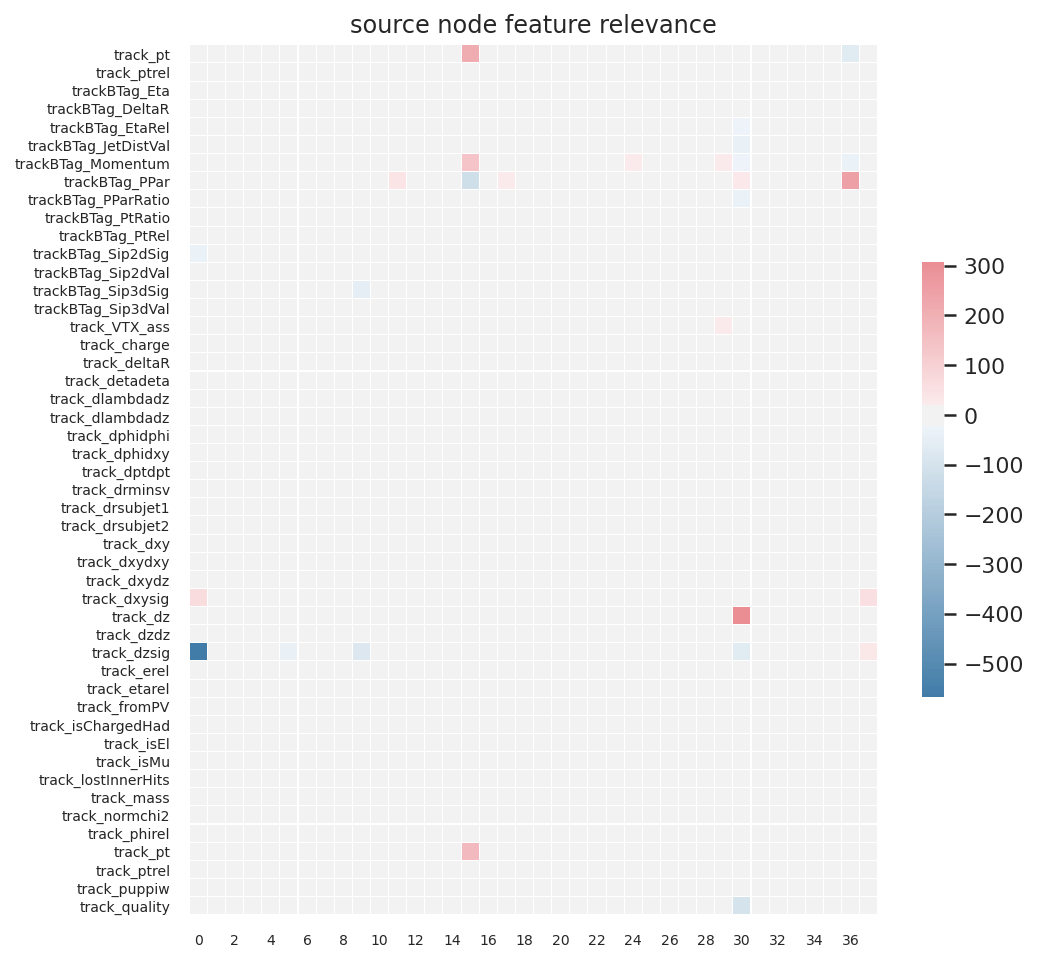

In [273]:
val=r.detach().cpu().numpy()
df=pd.DataFrame(val,columns=features).T

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
s=sns.heatmap(df, cmap=cmap, center=0,yticklabels=1,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})

s.tick_params(labelsize=7)

plt.title("source node feature relevance")
plt.show()